In [6]:
%load_ext autoreload
%autoreload 2

import os
import sys
sys.path.insert(0, "../src/")
import re
import numpy as np
import pandas as pd
from tqdm import tqdm
from handcrafted_features import DocBasedFeatureExtractor, Doc2VecChunkVectorizer, CorpusBasedFeatureExtractor
from utils import get_doc_paths, read_labels

raw_docs_dir = "../data/raw_docs/"
labels_dir = "../data/labels/"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
lang = "eng"
doc_paths = get_doc_paths(raw_docs_dir, lang)
sentences_per_chunk = 200
# d2vcv = Doc2VecChunkVectorizer(lang, sentences_per_chunk)
# d2vcv.fit_transform(doc_paths)

all_chunk_based_features = []
all_book_based_features = []
all_average_sbert_sentence_embeddings = []
all_doc2vec_chunk_embeddings = []
for doc_path in tqdm(doc_paths):
    fe = DocBasedFeatureExtractor(lang, doc_path, sentences_per_chunk)
    chunk_based_features, book_based_features, average_sbert_sentence_embeddings, doc2vec_chunk_embeddings = fe.get_all_features()
    all_chunk_based_features.extend(chunk_based_features)
    all_book_based_features.append(book_based_features)
    all_average_sbert_sentence_embeddings.append(average_sbert_sentence_embeddings)
    all_doc2vec_chunk_embeddings.append(doc2vec_chunk_embeddings)

cbfe = CorpusBasedFeatureExtractor(lang, doc_paths, all_average_sbert_sentence_embeddings, all_doc2vec_chunk_embeddings)
all_corpus_based_features = cbfe.get_all_features()


100%|██████████| 599/599 [00:50<00:00, 11.96it/s]
INFO:gensim.models.ldamodel:using symmetric alpha at 0.1
INFO:gensim.models.ldamodel:using symmetric eta at 0.1
INFO:gensim.models.ldamodel:using serial LDA version on this node
INFO:gensim.models.ldamulticore:running online LDA training, 10 topics, 2 passes over the supplied corpus of 599 documents, updating every 6000 documents, evaluating every ~599 documents, iterating 50x with a convergence threshold of 0.001000
INFO:gensim.models.ldamulticore:training LDA model using 3 processes
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #0 = documents up to #599/599, outstanding queue size 1
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:topic #6 (0.100): 0.011*"cecilia" + 0.007*"helen" + 0.004*"lucy" + 0.004*"jones" + 0.003*"sophia" + 0.003*"tho" + 0.003*"emily" + 0.002*"charlotte" + 0.002*"allan" + 0.002*"aurora"
INFO:gensim.models.ldamodel:topic #9 (0.100): 0.013*"laura" + 0.008*"molly" + 0.006

In [12]:
df = pd.DataFrame(all_chunk_based_features)
labels = read_labels(labels_dir, lang)
df["y"] = df["book_name"].apply(lambda x: labels[x])

../src/utils.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels_df["file_name"][labels_df["file_name"] == key] = value


In [ ]:
from sklearn.model_selection import KFold
from sklearn.svm import SVR
# from sklearn.decomposition import PCA
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

all_predictions = []
all_labels = []

book_names = df['book_name'].unique()
book_names_splitted = np.array_split(book_names, 10)

for index, split in enumerate(book_names_splitted):
    train_X = df[~df["book_name"].isin(split)].drop(columns=["y", "book_name"]).values
    train_y = df[~df["book_name"].isin(split)]["y"].values.ravel()
    validation_X = df[df["book_name"].isin(split)].drop(columns=["y", "book_name"]).values
    validation_y = df[df["book_name"].isin(split)]["y"].values.ravel()
    
    pca = PCA(n_components=150)
    train_X = pca.fit_transform(train_X)
    print(pca.explained_variance_ratio_.sum())
    validation_X = pca.transform(validation_X)
    model = XGBRegressor()
    model.fit(train_X, train_y)
    train_yhat = model.predict(train_X)
    validation_yhat = model.predict(validation_X)
    all_labels.extend(validation_y.tolist())
    all_predictions.extend(validation_yhat.tolist())
    train_mse = mean_squared_error(train_y, train_yhat)
    train_mae = mean_absolute_error(train_y, train_yhat)
    validation_mse = mean_squared_error(validation_y, validation_yhat)
    validation_mae = mean_absolute_error(validation_y, validation_yhat)
    print(f"Fold: {index+1}, TrainMSE: {train_mse}, TrainMAE: {train_mae}, ValMSE: {validation_mse}, ValMAE: {validation_mae}")
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

In [32]:
from sklearn.model_selection import KFold
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.decomposition import PCA

X = df.drop(columns=['y', 'book_name']).values
y = df["y"].values.ravel()

all_predictions = []
all_labels = []
kf = KFold(n_splits=10, shuffle=True, random_state=42)
for index, (train_indices, validation_indices) in enumerate(kf.split(X)):
    train_X = X[train_indices, :]
    train_y = y[train_indices]
    validation_X = X[validation_indices, :]
    validation_y = y[validation_indices]
    pca = PCA(n_components=150)
    train_X = pca.fit_transform(train_X)
    print(pca.explained_variance_ratio_.sum())
    validation_X = pca.transform(validation_X)
    model = SVR()
    model.fit(train_X, train_y)
    train_yhat = model.predict(train_X)
    validation_yhat = model.predict(validation_X)
    all_labels.extend(validation_y.tolist())
    all_predictions.extend(validation_yhat.tolist())
    train_mse = mean_squared_error(train_y, train_yhat)
    train_mae = mean_absolute_error(train_y, train_yhat)
    validation_mse = mean_squared_error(validation_y, validation_yhat)
    validation_mae = mean_absolute_error(validation_y, validation_yhat)
    print(f"Fold: {index+1}, TrainMSE: {train_mse}, TrainMAE: {train_mae}, ValMSE: {validation_mse}, ValMAE: {validation_mae}")
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)


Fold: 1, TrainMSE: 43.469667840289546, TrainMAE: 4.958794701188562, ValMSE: 824.3440447814484, ValMAE: 22.94768801594295
Fold: 2, TrainMSE: 40.991699673369105, TrainMAE: 4.767284888176421, ValMSE: 540.8243638243405, ValMAE: 17.786383218431926
Fold: 3, TrainMSE: 36.084968600997875, TrainMAE: 4.647670188989748, ValMSE: 488.05888410849894, ValMAE: 17.99337098662573
Fold: 4, TrainMSE: 44.249400353139144, TrainMAE: 5.035168938639897, ValMSE: 657.8716684842817, ValMAE: 21.349721766633383
Fold: 5, TrainMSE: 41.06465995698478, TrainMAE: 4.788829998088479, ValMSE: 624.1233646633849, ValMAE: 19.854370166934935
Fold: 6, TrainMSE: 35.22251945619247, TrainMAE: 4.437842820080085, ValMSE: 877.2025223967174, ValMAE: 24.325287052149395
Fold: 7, TrainMSE: 35.78601749032129, TrainMAE: 4.511772336979252, ValMSE: 728.8424851143518, ValMAE: 21.012765171207395
Fold: 8, TrainMSE: 41.15389563461156, TrainMAE: 4.907933288177313, ValMSE: 522.9483832400464, ValMAE: 17.31974220736049
Fold: 9, TrainMSE: 39.45136757

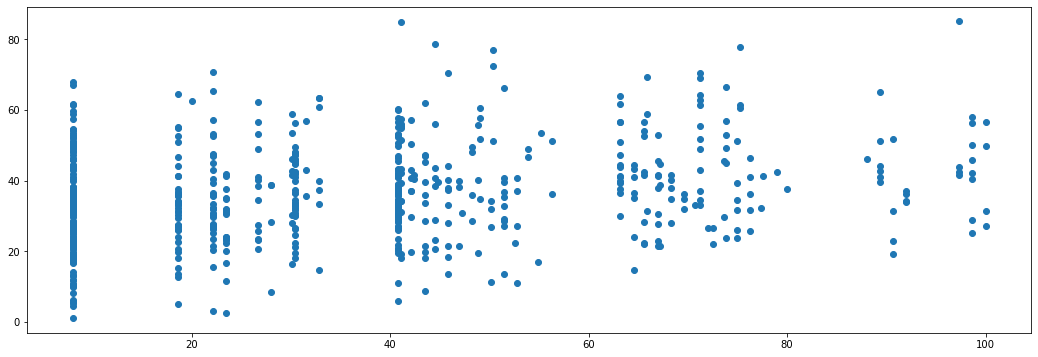

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 6))
plt.scatter(all_labels, all_predictions)
plt.show();